# Assignment 1
Name: Jaimon Thypramabil Thomas
<br>StudentID : 29566428

### Library Used

In [1]:
library(reshape2) # used for melt function
library(ggplot2) # used for generating plots

Warning message:
"package 'reshape2' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"

## Section B. Prediction Uncertainty with Bootstrapping

### Question 3 [Bootstrapping, 25 Marks]

#### I. Modify the code in Activity 2 to handle bootstrapping for KNN regression.

In [2]:
#function used to calculate average of an array
averageCalculator <- function(x) {
    return(round((sum(x)/length(x)),2))
}

# KNN Regressor function returns predicted values based on manhattan distance
knn.regressor <- function(train.data, train.label, test.data, K=3){
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples using manhattan
    dist <- as.matrix(dist(rbind(test.data, train.data), method= 'manhattan'))[1:test.len, (test.len+1):(test.len+train.len)]
    predict.label = rep(0,test.len)
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        if(test.len == 1){
            #Extracting the top K value indexes based on sorted distances
            nn <- as.data.frame(sort(dist, index.return = TRUE))[1:K,2]
        }
        else{
            #Extracting the top K value indexes based on sorted distances
            nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        }
        ###... and calculate the predicted value according to the average value
        predict.label[i]<- (averageCalculator(train.label[nn]))
    }
    ## return the class labels as output
    return (predict.label)
}

In [3]:
# define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=100){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

#function used to apply bootstraping technique on knn regressor
knn.regressor.boot <-function(train.data,train.label,test.data,test.label,K = 1:15,sample.size=20,times = 50){
    L <- times           # number of datasets
    N <- sample.size    # size of datasets
    # generate bootstrap indices:
    # a dataframe to track the number of average error in each case
    miss <- data.frame('K'=K, 'L'=1:L,'N'=N,'test'=rep(0,L*length(K)*length(N)))
    
    # THIS MAY TAKE A FEW MINUTES TO COMPLETE
    ## for every k values:
    i = 0
    for (k in K){
        for(n in N){
            boot.indx <- boot(nrow(train.data), n, L)
            for (l in 1:L){
                i = i +1
                #### calculate iteration index i

                #### save sample indices that were selected by bootstrap
                indx <- boot.indx[l,]

                #### save the value of k and l
                miss[i,'K'] <- k
                miss[i,'L'] <- l
                miss[i,'N'] <- n

                #### calculate and record the test average error
                miss[i,'test'] <- sum((knn.regressor(train.data[indx, ],train.label[indx], test.data, K=k) - test.label)**2)/length(test.label)
            } 
        }        
    }
    return(miss)
}

#### II. Load Task1B_train.csv and Task1B_test.csv sets. Apply your bootstrapping for KNN regression with times = 50 (the number of subsets), size = 20 (the size of each subset), and change K=1,.., 15 (the neighbourhood size). Now create a boxplot where the x-axis is K, and the y-axis is the average error (and the uncertainty around it) corresponding to each K. Save the plot in your Jupyter Notebook file for Question 3.
#### Hint: You can refer to the boxplot in Activity 2 of Module 1. But the error is measured in different ways compared with the KNN classifier.

#### Loading the data

In [4]:
#Reading data from csv
task1B_train <- read.csv("Task1B_train.csv")
task1B_test <- read.csv("Task1B_test.csv")
head(task1B_test)

x1,x2,x3,x4,y
1991.500,1613.63,1688.5,1750.5,2460.2
1991.508,1621.04,1684.1,1708.1,2470.4
1991.515,1610.61,1671.6,1714.3,2466.8
1991.523,1640.17,1703.6,1757.4,2508.4
1991.531,1645.89,1716.3,1754.3,2497.4
1991.538,1638.35,1730.5,1755.5,2556.8


In [5]:
trainB.data <- task1B_train[, -5]
trainB.label <- task1B_train[, 5]
testB.data <- task1B_test[, -5]
testB.label <- task1B_test[, 5]

In [6]:
# set random seed
set.seed(1234)
miss.B <- knn.regressor.boot(trainB.data,trainB.label,testB.data,testB.label,K = 1:15,sample.size=20,times = 50)

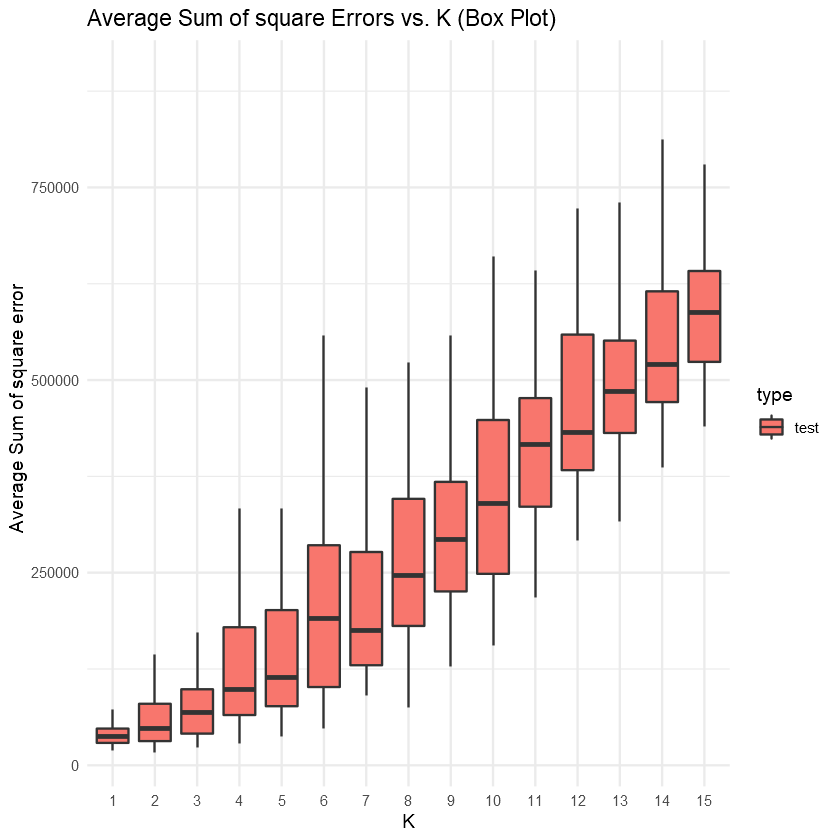

In [7]:
# plot Average Sum of Errors vs. K (Box Plot)
miss.B.m <- melt(miss.B, id=c('K', 'L','N')) # reshape for visualization
names(miss.B.m) <- c('K', 'L','N', 'type', 'average.error')
ggplot(data=miss.B.m[miss.B.m$type=='test',], aes(factor(K), average.error,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
labs( title= "Average Sum of square Errors vs. K (Box Plot)", y=" Average Sum of square error",
           x = "K")  + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

#### III. Based on the plot in the previous part (Part П), how does the test error and its uncertainty behave as K increases? Explain in your Jupyter Notebook file.

Here from the above plot we can see that generally as K increases test error increases. We can also see that there is no particular pattern regadring uncertainity for different values of K

#### IV. Load Task1B_train.csv and Task1B_test.csv sets. Apply your bootstrapping for KNN regression with K= 5(the neighbourhood size), times = 50 (the number of subsets), and change sizes = 5, 10, 15,..., 75 (the size of each subset). Now create a boxplot where the x-axis is ‘sizes’ and the y-axis is the average error (and the uncertainty around it) corresponding to each value of ‘times’. Save the plot in your Jupyter Notebook file for Question 3.

In [8]:
#function used to generate a series of no between start and end increased by a factor
getseries <-function(start,end,factor){
    temp = 0
    i=start
    while(i<=end){
        if(i==start) { temp = start }
        else { temp = c(temp,i) }
        i =i+factor
    } 
    return(temp)
}

In [9]:
# set random seed
set.seed(1234)
miss.B.size <- knn.regressor.boot(trainB.data,trainB.label,testB.data,testB.label,K = 5,
                                  sample.size=getseries(5,75,5),times = 50)

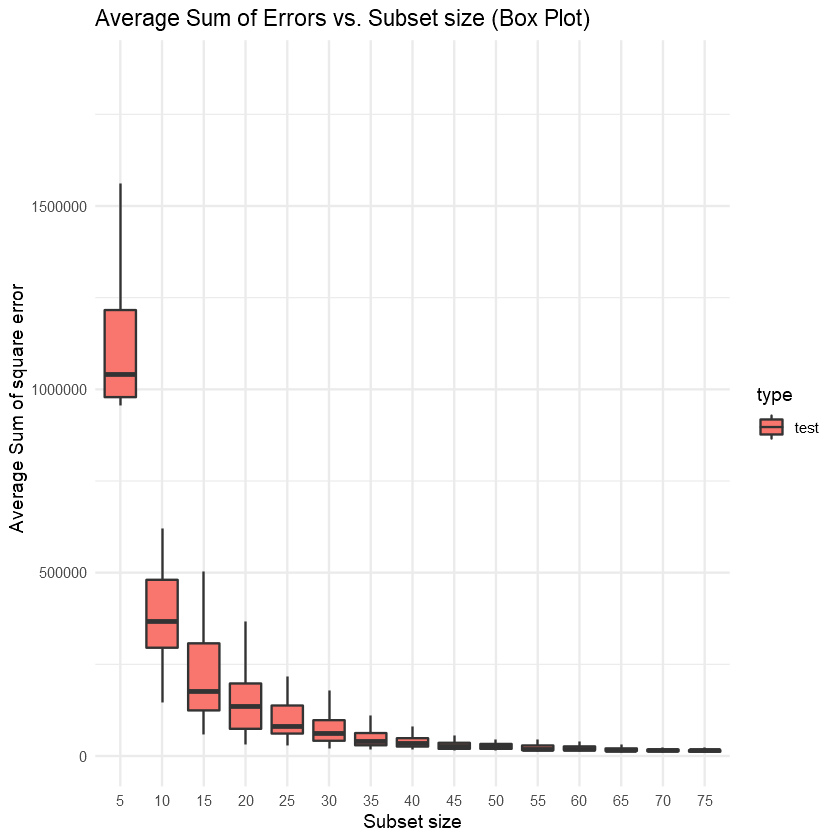

In [10]:
# plot Average Sum of Errors vs. Subset size (Box Plot)
miss.B.size.m <- melt(miss.B.size, id=c('K', 'L','N')) # reshape for visualization
names(miss.B.size.m) <- c('K', 'L','N', 'type', 'average.error')
ggplot(data=miss.B.size.m[miss.B.size.m$type=='test',], aes(factor(N), average.error,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
labs( title= "Average Sum of Errors vs. Subset size (Box Plot)", y=" Average Sum of square error",
           x = "Subset size") + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

#### V. Based on the plot in the previous part (Part IV), how does the test error and its uncertainty behave as the size of each subset in bootstrapping increases? Explain in your Jupyter Notebook file.

From the above plot we can see that as the size of each subset in bootstrapping increases we can see that the average error and its uncertainity decreasing